### World Bank Data Analysis

In [18]:
import pandas as pd

# Load the CSV
df = pd.read_csv('world_bank_data_2025.csv')

# Drop columns with more than 50% missing values
threshold = len(df) * 0.5
df_cleaned = df.dropna(thresh=threshold, axis=1)

# Drop rows missing essential fields
df_cleaned = df_cleaned.dropna(subset=['country_name', 'year'])

# Convert year to datetime for time-based plots
df_cleaned['year'] = pd.to_datetime(df_cleaned['year'], format='%Y')

# Optional: View remaining columns and missing counts
print(df_cleaned.columns)
print(df_cleaned.isnull().sum())


Index(['country_name', 'country_id', 'year', 'Inflation (CPI %)',
       'GDP (Current USD)', 'GDP per Capita (Current USD)',
       'Unemployment Rate (%)', 'Inflation (GDP Deflator, %)',
       'GDP Growth (% Annual)', 'Current Account Balance (% GDP)',
       'Government Expense (% of GDP)', 'Government Revenue (% of GDP)',
       'Tax Revenue (% of GDP)', 'Gross National Income (USD)'],
      dtype='object')
country_name                          0
country_id                            0
year                                  0
Inflation (CPI %)                   778
GDP (Current USD)                   539
GDP per Capita (Current USD)        534
Unemployment Rate (%)               677
Inflation (GDP Deflator, %)         568
GDP Growth (% Annual)               560
Current Account Balance (% GDP)     909
Government Expense (% of GDP)      1652
Government Revenue (% of GDP)      1643
Tax Revenue (% of GDP)             1639
Gross National Income (USD)         676
dtype: int64


## Gov Revenue vs Gov Expense

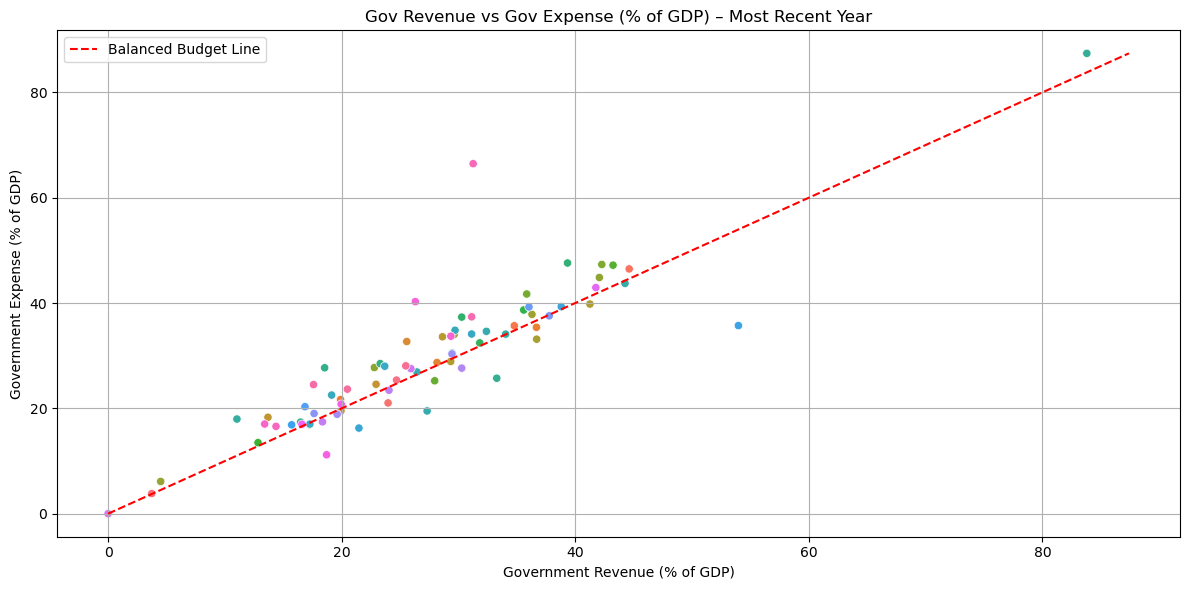

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("world_bank_data_2025.csv")
df['year'] = pd.to_datetime(df['year'], format='%Y')

# Filter latest year and remove rows with missing fiscal data
df_fiscal = df.dropna(subset=['Government Expense (% of GDP)', 'Government Revenue (% of GDP)'])
latest_year = df_fiscal['year'].max()
df_fiscal = df_fiscal[df_fiscal['year'] == latest_year]

# Plot
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=df_fiscal,
    x='Government Revenue (% of GDP)',
    y='Government Expense (% of GDP)',
    hue='country_name',
    legend=False
)
plt.plot(
    [0, df_fiscal[['Government Revenue (% of GDP)', 'Government Expense (% of GDP)']].max().max()],
    [0, df_fiscal[['Government Revenue (% of GDP)', 'Government Expense (% of GDP)']].max().max()],
    'r--', label='Balanced Budget Line'
)
plt.title('Gov Revenue vs Gov Expense (% of GDP) – Most Recent Year')
plt.xlabel('Government Revenue (% of GDP)')
plt.ylabel('Government Expense (% of GDP)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Public Debt vs GDP Growth

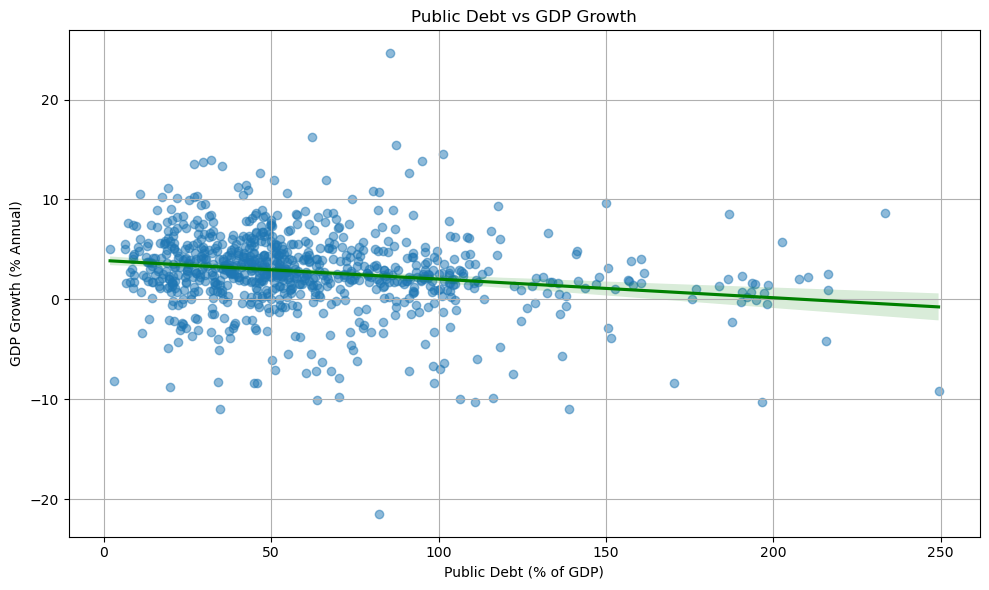

In [3]:
# Drop rows with missing debt and growth values
df_debt = df.dropna(subset=['Public Debt (% of GDP)', 'GDP Growth (% Annual)'])

# Plot
plt.figure(figsize=(10, 6))
sns.regplot(
    data=df_debt,
    x='Public Debt (% of GDP)',
    y='GDP Growth (% Annual)',
    scatter_kws={'alpha': 0.5},
    line_kws={'color': 'green'}
)
plt.title('Public Debt vs GDP Growth')
plt.xlabel('Public Debt (% of GDP)')
plt.ylabel('GDP Growth (% Annual)')
plt.grid(True)
plt.tight_layout()
plt.show()


## GDP Growth vs Unemployment Rate

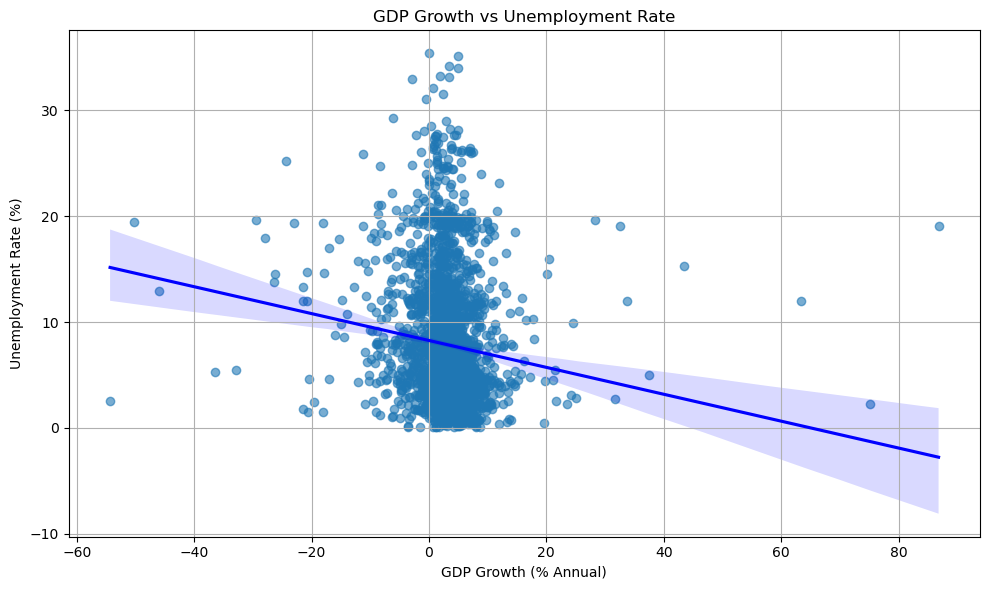

In [4]:
# Drop missing values
df_unemp = df.dropna(subset=['GDP Growth (% Annual)', 'Unemployment Rate (%)'])

# Plot
plt.figure(figsize=(10, 6))
sns.regplot(
    data=df_unemp,
    x='GDP Growth (% Annual)',
    y='Unemployment Rate (%)',
    scatter_kws={'alpha': 0.6},
    line_kws={'color': 'blue'}
)
plt.title('GDP Growth vs Unemployment Rate')
plt.xlabel('GDP Growth (% Annual)')
plt.ylabel('Unemployment Rate (%)')
plt.grid(True)
plt.tight_layout()
plt.show()


## US Economic Forecast

/var/folders/q5/ktm6z3_158xcp44j8xzrnw400000gn/T/ipykernel_75649/987094370.py:23: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  future_years = pd.date_range(start='2026', end='2030', freq='Y')


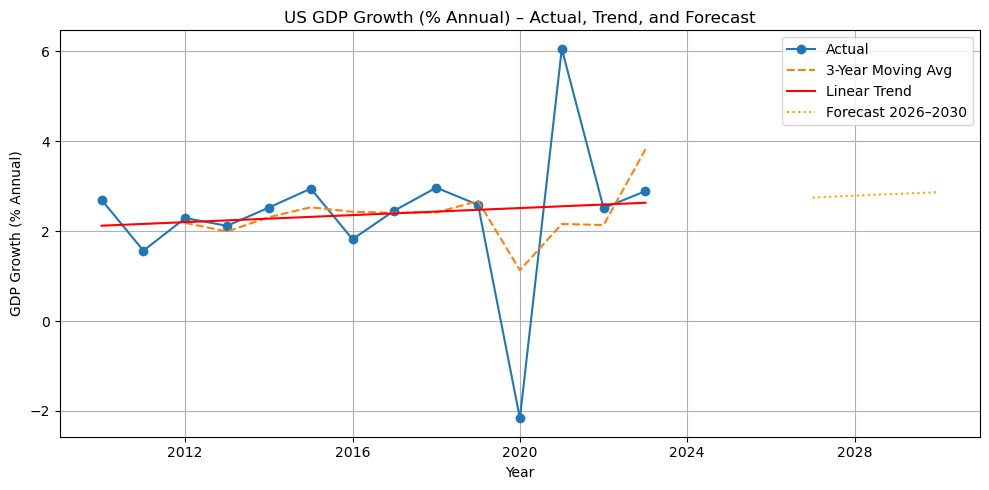

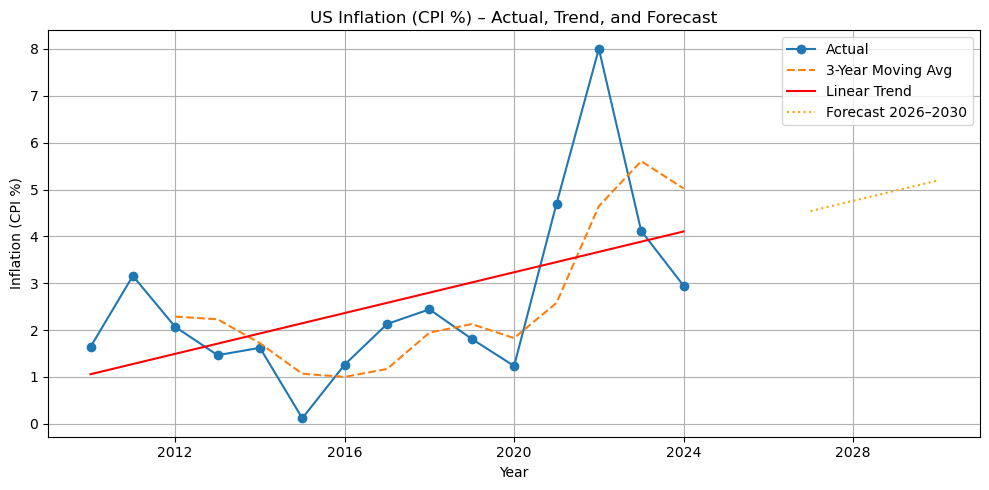

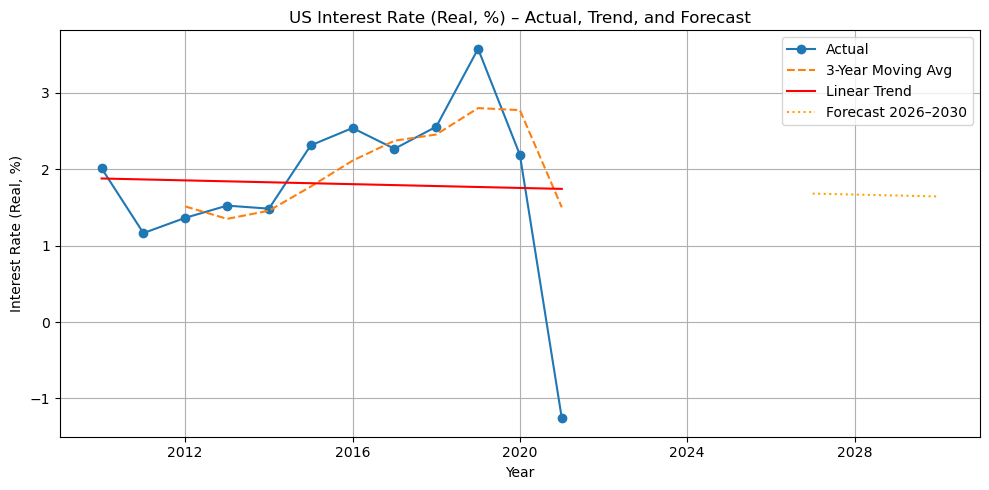

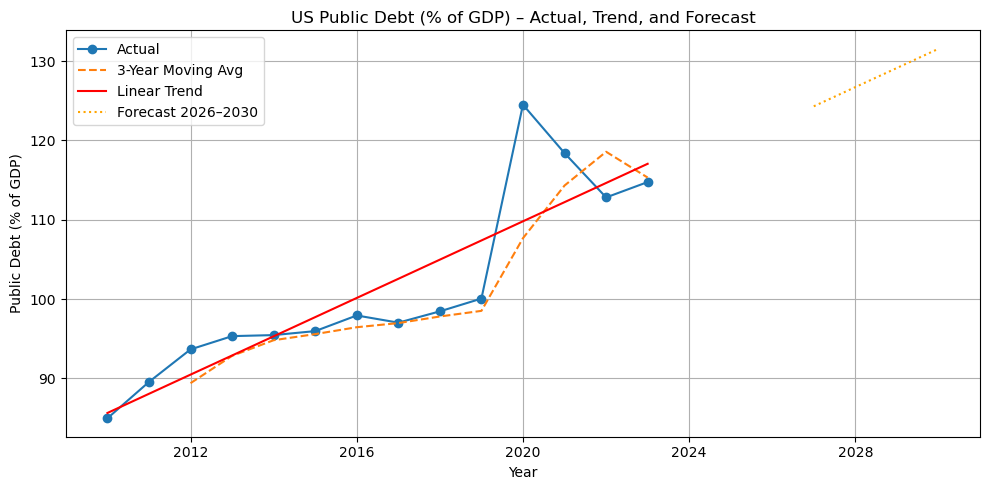

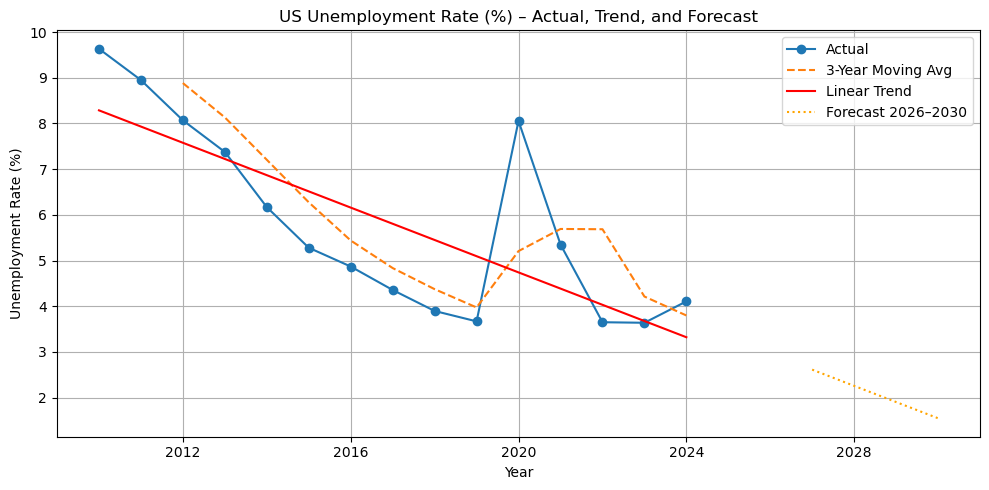

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Load the dataset
df = pd.read_csv("world_bank_data_2025.csv")
df['year'] = pd.to_datetime(df['year'], format='%Y')

# Filter for United States only
df_us = df[df['country_name'] == 'United States'].sort_values('year')

# List of indicators to model
indicators = [
    'GDP Growth (% Annual)',
    'Inflation (CPI %)',
    'Interest Rate (Real, %)',
    'Public Debt (% of GDP)',
    'Unemployment Rate (%)'
]

# Define future years for forecasting
future_years = pd.date_range(start='2026', end='2030', freq='Y')
future_year_nums = np.array([d.year for d in future_years]).reshape(-1, 1)

# Loop through each indicator
for indicator in indicators:
    df_ind = df_us.dropna(subset=[indicator]).copy()
    df_ind['year_num'] = df_ind['year'].dt.year

    # Fit linear regression model
    X = df_ind[['year_num']]
    y = df_ind[indicator]
    model = LinearRegression()
    model.fit(X, y)

    # Predict on existing data
    df_ind['predicted'] = model.predict(X)

    # Predict for future years
    future_preds = model.predict(pd.DataFrame(future_year_nums, columns=['year_num']))
    df_future = pd.DataFrame({
        'year': future_years,
        'year_num': future_year_nums.flatten(),
        'predicted': future_preds
    })

    # Add moving average
    df_ind['moving_avg'] = df_ind[indicator].rolling(window=3).mean()

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(df_ind['year'], df_ind[indicator], marker='o', label='Actual')
    plt.plot(df_ind['year'], df_ind['moving_avg'], linestyle='--', label='3-Year Moving Avg')
    plt.plot(df_ind['year'], df_ind['predicted'], linestyle='-', color='red', label='Linear Trend')
    plt.plot(df_future['year'], df_future['predicted'], linestyle=':', color='orange', label='Forecast 2026–2030')
    plt.title(f'US {indicator} – Actual, Trend, and Forecast')
    plt.xlabel('Year')
    plt.ylabel(indicator)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


## Calculating Investment Score

In [33]:
# Load your data
df = pd.read_csv("world_bank_data_2025.csv")

# Filter for the most recent 3 years
df_recent = df[df['year'].isin([2023, 2024, 2025])]

# Group by country and calculate the mean of each metric
df_avg = df_recent.groupby('country_name', as_index=False).agg({
    'GDP Growth (% Annual)': 'mean',
    'Inflation (CPI %)': 'mean',
    'Unemployment Rate (%)': 'mean',
    'Public Debt (% of GDP)': 'mean'
})

# Define normalization function
def normalize(series, higher_is_better=True):
    if higher_is_better:
        return (series - series.min()) / (series.max() - series.min())
    else:
        return (series.max() - series) / (series.max() - series.min())

# Normalize each indicator
df_avg['Norm_GDP_Growth'] = normalize(df_avg['GDP Growth (% Annual)'], True)
df_avg['Norm_Inflation'] = normalize(df_avg['Inflation (CPI %)'], False)
df_avg['Norm_Unemployment'] = normalize(df_avg['Unemployment Rate (%)'], False)
df_avg['Norm_Debt'] = normalize(df_avg['Public Debt (% of GDP)'], False)

# Calculate Investment Score (weighted average)
df_avg['Investment Score'] = (
    0.4 * df_avg['Norm_GDP_Growth'] +
    0.2 * df_avg['Norm_Inflation'] +
    0.2 * df_avg['Norm_Unemployment'] +
    0.2 * df_avg['Norm_Debt']
)

# Sort countries by Investment Score
df_sorted = df_avg.sort_values(by='Investment Score', ascending=False)

# View top 10
print(df_sorted[['country_name', 'Investment Score']].head(10))

# Export the scores to CSV
df_sorted.to_csv('investment_scores.csv', index=False)


         country_name  Investment Score
100        Kazakhstan          0.663173
188       Switzerland          0.657037
129           Moldova          0.648752
107   Kyrgyz Republic          0.646483
29           Bulgaria          0.645635
127            Mexico          0.642780
202            Uganda          0.642540
152  Papua New Guinea          0.637246
192          Thailand          0.633784
104       Korea, Rep.          0.629313
